# Probabilistic Algorithms

## Traveling Salesman Problem

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
import pandas as pd
import numpy as np
import scipy.spatial as sp
from tsp.tsp import TravelingSalesmanProblem
import tsp.tsp_heuristic as th

from matplotlib import pyplot as plt

In [23]:
from matplotlib import collections as mc

def build_plot(heuristic_result):
    plt.rcParams['figure.figsize'] = (14, 9)
    start = heuristic_result.get_starting_node_for_plotting()
    x, y = np.array(heuristic_result.get_tour_for_plotting()).T
    plt.plot(x, y)
    plt.plot(start[0],start[1],"ro")
    plt.title("Distance travelled: {}".format(heuristic_result.get_tour_length()))
    plt.axis('off')
    plt.show()

In [5]:
nodes = pd.read_csv("TSP_411.txt", sep='\s+', names=['node', 'x', 'y'])

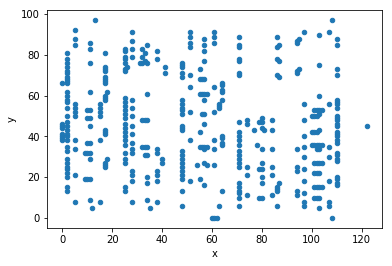

In [6]:
nodes.plot(kind='scatter', x='x',y='y')

In [7]:
tsp = TravelingSalesmanProblem(nodes)

In [30]:
bestinsert = th.BestInsertion(tsp)

In [31]:
bestinsert.calculate_tour()

Current nodes in tour: [(31, 399), (399, 269), (269, False)].
The deltas:[0.21668599728809568, 0.8519856927957861, 62.668404659277684].
Will insert 366 between: (31, 399)


Current nodes in tour: [(366, 399), (269, False)].
The deltas:[203.98173862645456, 0.7280491176843213].
Will insert 30 between: (269, False)


Current nodes in tour: [(269, 399), (366, 399), (30, False)].
The deltas:[114.49353595391963, 177.5109932370637, 85.37777863247379].
Will insert 79 between: (30, False)




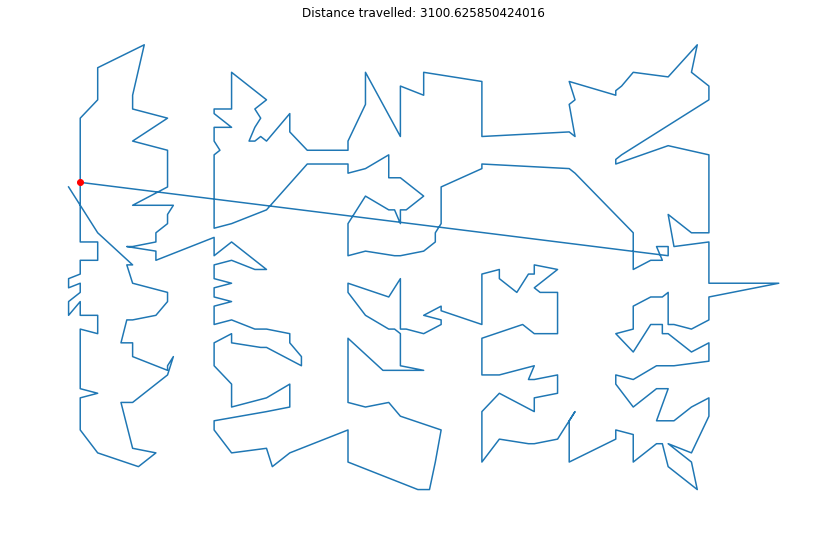

In [32]:
build_plot(bestinsert)

### Best-Best Insertion

In [33]:
bbinsert = th.BestBestInsertion(tsp)

In [34]:
bbinsert.calculate_tour()

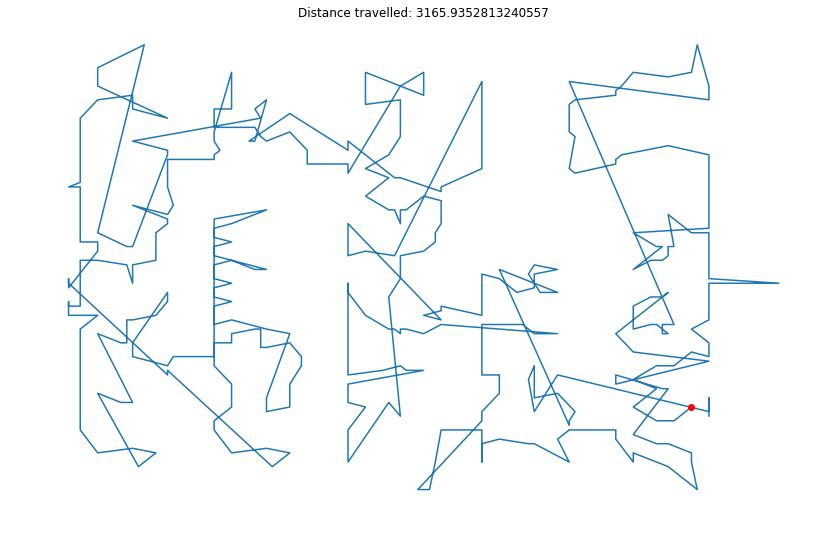

In [35]:
build_plot(bbinsert)